## Usual imports

In [1]:
import pandas as pd
import numpy as np
import sys, math, os, json, re, random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from pathlib import Path

from numerapi import NumerAPI
from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    validation_metrics,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL
)

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
from numerapi import NumerAPI
napi = NumerAPI()

In [3]:
# napi.download_dataset("v4/train.parquet", "data/train.parquet")
# napi.download_dataset("v4/validation.parquet", "data/validation.parquet")
# napi.download_dataset("v4/live.parquet", "data/live.parquet")
# napi.download_dataset("v4/live_example_preds.parquet", "data/live_example_preds.parquet")
# napi.download_dataset("v4/validation_example_preds.parquet", "data/validation_example_preds.parquet")
# napi.download_dataset("v4/features.json", "data/features.json")

In [4]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [5]:
# read the feature metadata and get a feature set (or all the features)
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)
    
# features = list(feature_metadata["feature_stats"].keys()) # get all the features
features = feature_metadata["feature_sets"]["small"] # get the small feature set
# features = feature_metadata["feature_sets"]["medium"] # get the medium feature set

# read in just those features along with era and target columns
read_columns = features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]

In [6]:
# note: sometimes when trying to read the downloaded data you get an error about invalid magic parquet bytes...
# if so, delete the file and rerun the napi.download_dataset to fix the corrupted file
training_data = pd.read_parquet('data/train.parquet',
                                columns=read_columns)
validation_data = pd.read_parquet('data/validation.parquet',
                                  columns=read_columns)
live_data = pd.read_parquet(f'data/live.parquet',
                                  columns=read_columns)

In [7]:
training_data

,feature_bijou_penetrant_syringa,feature_burning_phrygian_axinomancy,feature_censorial_leachier_rickshaw,feature_coastal_edible_whang,feature_coraciiform_sciurine_reef,feature_corporatist_seborrheic_hopi,feature_cyclopedic_maestoso_daguerreotypist,feature_distressed_bloated_disquietude,feature_ecstatic_foundational_crinoidea,feature_elaborate_intimate_bor,...,feature_undrilled_wheezier_countermand,feature_unpainted_censual_pinacoid,feature_unreproved_cultish_glioma,feature_unsizable_ancestral_collocutor,feature_unsustaining_chewier_adnoun,feature_unswaddled_inenarrable_goody,feature_unventilated_sollar_bason,era,data_type,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0.00,0.00,0.50,0.25,0.50,1.00,0.50,0.50,0.00,0.50,...,0.75,1.00,1.00,0.50,0.25,0.25,0.00,0001,train,0.25
n003bee128c2fcfc,0.50,0.75,0.75,0.75,0.50,0.25,0.50,0.75,1.00,0.75,...,0.25,1.00,0.25,0.50,1.00,0.75,0.25,0001,train,0.75
n0048ac83aff7194,0.25,0.25,1.00,0.75,1.00,0.75,0.75,0.75,0.75,0.75,...,0.75,0.00,0.25,1.00,1.00,0.75,1.00,0001,train,0.50
n00691bec80d3e02,0.75,0.75,0.00,0.00,0.75,0.25,0.25,0.00,0.00,0.00,...,0.50,1.00,0.00,0.50,0.00,0.50,0.75,0001,train,0.75
n00b8720a2fdc4f2,0.00,0.00,0.50,0.25,0.00,1.00,0.25,0.25,0.75,0.25,...,0.25,1.00,0.00,0.00,0.25,1.00,0.00,0001,train,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,1.00,0.25,0.75,0.75,0.75,1.00,0.75,1.00,0.25,1.00,...,0.75,0.75,0.25,1.00,0.75,0.50,1.00,0574,train,0.75
nffd71b7f6a128df,0.75,0.00,0.00,0.00,0.50,0.50,0.00,0.25,0.00,0.00,...,0.00,0.00,1.00,0.25,0.00,0.25,0.50,0574,train,0.00
nffde3b371d67394,0.75,0.00,0.00,0.00,1.00,1.00,0.75,1.00,0.00,1.00,...,1.00,0.50,0.50,1.00,0.00,1.00,1.00,0574,train,0.25


In [8]:
target = "target"
targets = [c for c in training_data if c.startswith("target")]
len(targets)

1

In [9]:
training_data["erano"] = training_data.era.astype(int)
eras = training_data.erano
target = "target_nomi_v4_20"
print(len(features))
print(features[:5])

38
['feature_bijou_penetrant_syringa', 'feature_burning_phrygian_axinomancy', 'feature_censorial_leachier_rickshaw', 'feature_coastal_edible_whang', 'feature_coraciiform_sciurine_reef']


In [10]:
# There are 574 eras numbered from 1 to 574
eras.describe()

count    2.420521e+06
mean     3.042725e+02
std      1.598538e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

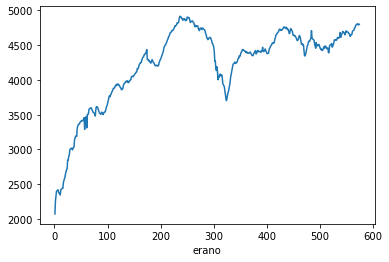

In [11]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
training_data.groupby(eras).size().plot();

In [12]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
training_data.groupby(target).size()/len(training_data)

target_nomi_v4_20
0.00    0.050007
0.25    0.200001
0.50    0.499975
0.75    0.200014
1.00    0.050003
dtype: float64

Eras are weekly (5 days), but the target is four weeks out (20 days).